<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Кросс-валидация" data-toc-modified-id="Кросс-валидация-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Кросс-валидация</a></span><ul class="toc-item"><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#Cat-Boost-Regressor" data-toc-modified-id="Cat-Boost-Regressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Cat Boost Regressor</a></span></li></ul></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBM</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания перевозчик собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Задача проекта:**

На основе собранных данных:
* данные лежат в файле `taxi.csv`
* количество заказов находится в столбце `num_orders`

протестировать несколько моделей регрессии и выбрать лучшую по метрике *RMSE*. Условие - на тестовой выборке выбранная модель должна показать  *RMSE* не больше 48.

**План проекта:**

1. Загрузить данные и выполнить их ресемплирование по одному часу
2. Проанализировать данные
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных
4. Проверить данные на тестовой выборке и сделать выводы

## Подготовка

In [1]:
# подготавливаем рабочее пространство,
# загружаем библиотеки
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
# загружаем данные, признак даты делаем признаком, преобразуем датафрейм во временной ряд,
# выводим информацию по датасету,
# выводим первые 5 строк
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.info())
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# производим сортировку по индексу,
# делаем ресемплирование по 1 часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы
* исходный датасет содержит 26 496 записей и 2 колонки
* частота данных зафиксирована с интервалом 10 мин
* датасет не содержит пропущенных значений
* колонка datetime приведена к формату datetime и выведена в индекс
* произведено ресемплирование на уровне 1 часа
* по результатам ресемплирования датасет сжался до 4 416 записей

## Анализ

In [4]:
# проверяем распределение данных на монотонность
print(data.index.is_monotonic)

True


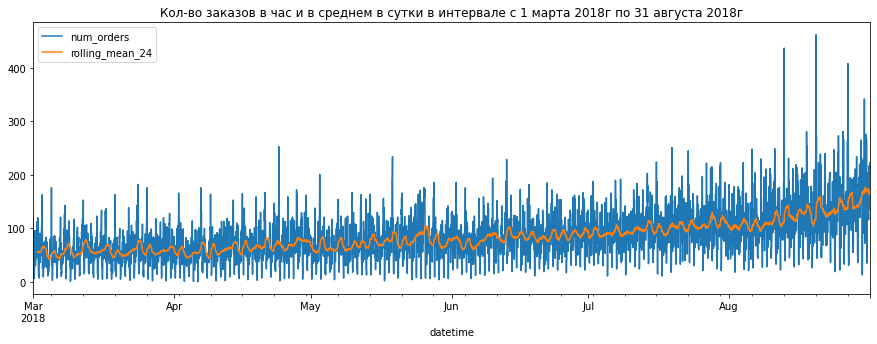

In [5]:
# визуализируем данные,
# добавляем сглаженный ряд
data['rolling_mean_24'] = data['num_orders'].shift().rolling(24).mean() 
data.plot(figsize=(15, 5))
plt.title('Кол-во заказов в час и в среднем в сутки в интервале с 1 марта 2018г по 31 августа 2018г')
plt.show()

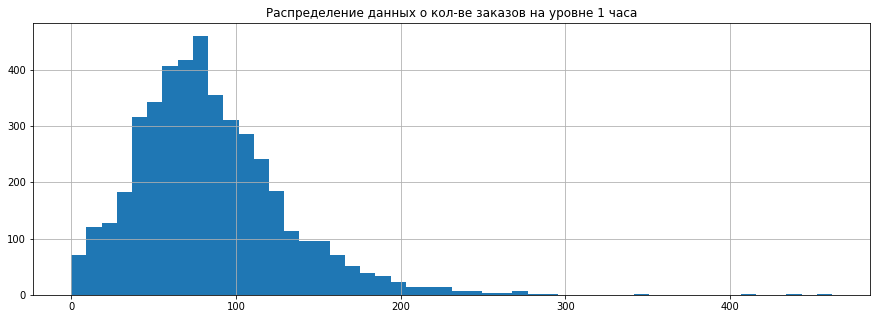

In [6]:
plt.figure(figsize=(15, 5))
data['num_orders'].hist(bins=50)
plt.title('Распределение данных о кол-ве заказов на уровне 1 часа');

In [7]:
# выводим стат данные по заказам
display(data['num_orders'].describe())

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

**Выводы по графикам и данным:**
* значения индекса расположены в хронологическом порядке
* данные о заказах имеют унимодальное распределение, скошенное вправо
* среднее значение равно 84.43 заказа в час
* медиана меньше среднего и равна 78 заказам в час
* 75% данных находятся в пределах 107 заказов в час
* имеются выбросы в диапазоне 300 - 462 заказа, которые приходятся на пиковые всплески августа
* заметны колебания по дням

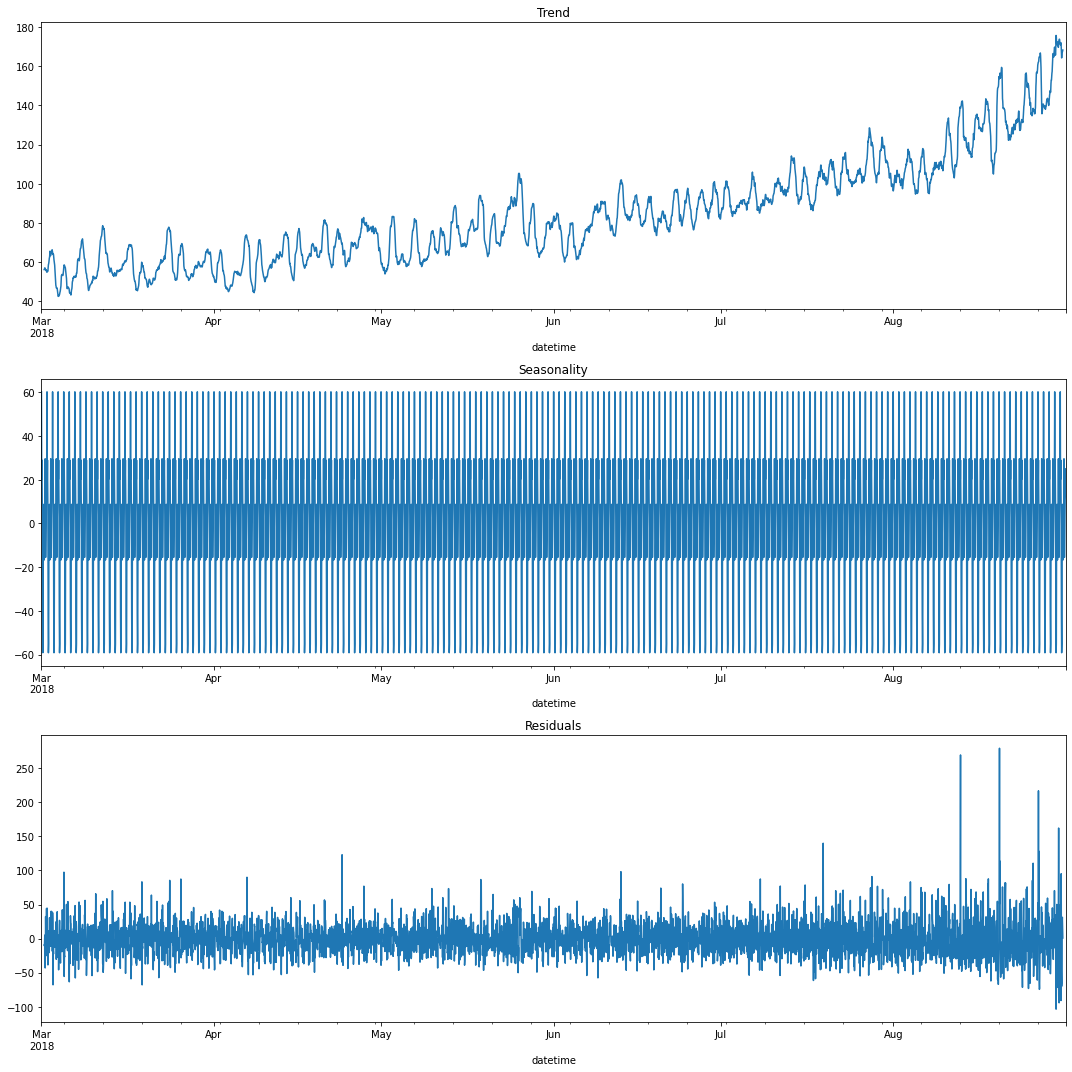

In [8]:
# проверяем тренд и сезонность
data = data.drop('rolling_mean_24', axis = 1)
decomposed = seasonal_decompose(data)
 
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Выводы по графикам:**
* объем авиаперевозок и соответственно пассажиропотока имеет ярко выраженную сезонность и зависит от:
> времени года
>
> традиционных периодов отпусков
>
> длинных выходных
>
> дня недели
>
> времени суток

* данные предоставлены за период, по которому невозможно оценить сезонность, т.к. он покрывает только часть года с марта по август; для качественной оценки сезонности необходимы данные минимум за 12 месяцев, а лучше за несколько лет
* тренд условно можно назвать "растущим", но опять же в связи с предоставленным временным периодом, невозможно сделать четкий вывод является ли наблюдаемый рост трендом или сезонностью

In [9]:
# создаем функцию, определяющую границы верхнего уса
def upper_limit(column):
    quantiles = data[column].quantile([0.25, 0.5, 0.75])
    q1 = quantiles[0.25]
    q3 = quantiles[0.75]
    upper_limit = q3 + 1.5*(q3 - q1)
    return upper_limit

In [10]:
# рассчитываем границу верхнего уса для кол-ва заказов
print("Граница верхнего уса:", upper_limit('num_orders'))

Граница верхнего уса: 186.5


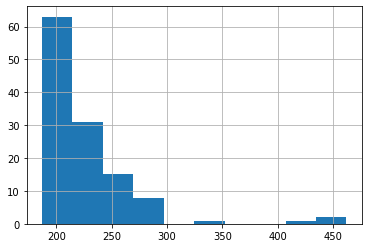

In [11]:
# проверяем распределение данных выше границы верхнего уса
data[data['num_orders'] > 186.5]['num_orders'].hist();

In [12]:
# убираем выбросы
data = data[data['num_orders'] <= 186.5]

In [13]:
# добавляем календарные признаки месяц, день (число), день недели
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['week'] = data.index.isocalendar().week.astype('int')
display(data.head(2))

,num_orders,month,day,dayofweek,week
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,9
2018-03-01 01:00:00,85,3,1,3,9


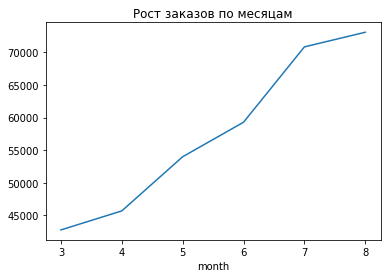

In [14]:
# проверяем изменение кол-ва заказов по месяцам
data.groupby('month')['num_orders'].sum().plot(title='Рост заказов по месяцам');

**Выводы по графику:**
* с марта наблюдается постоянный рост кол-ва заказов
* с июня по август в период летних отпусков и каникул рост происходит в геометрической прогрессии

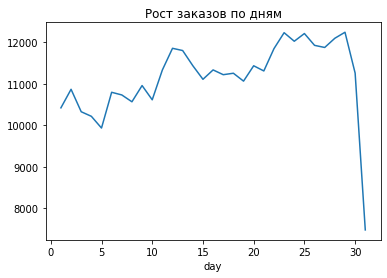

In [15]:
# проверяем изменение кол-ва заказов по дням
data_day = data.groupby('day')['num_orders'].sum()
data_day.plot(title='Рост заказов по дням');

**Выводы по графику:**
* прослеживаются определенные закономерности в распределении пассажиропотока в зависимости от дня месяца (числа)
* колебания от даты к дате скорее всего также связаны с днями недели
* есть 2 основных всплеска - в середине и в конце месяца, что может быть связано с выплатой авансов и получек

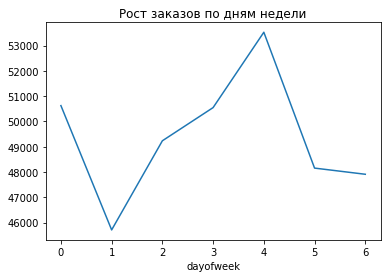

In [16]:
# проверяем изменение кол-ва заказов по дням
data_dayofweek = data.groupby('dayofweek')['num_orders'].sum()
data_dayofweek.plot(title='Рост заказов по дням недели');

**Выводы по графику:**
* минимальное кол-во заказов приходится на вторники
* со вторника по пятницу идет рост с пиком в пятницу
* пик в пятницу очевидно обусловлен наслаиванием двух процессов: возвращением из командировок и вылетом на выходные
* также пик наблюдается в понедельник, очевидно, по аналогичным причинам: возвращение с выходных и вылеты в командировки

## Обучение

### Подготовка

In [17]:
# добавляем признаки с лагами до 5,
# признак скользящего среднего,
# удаляем пропущенные значения
for lag in range(1, 6):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['roll_5_mean'] = data['num_orders'].shift().rolling(5).mean()
data = data.dropna()
display(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4290 entries, 2018-03-01 05:00:00 to 2018-08-31 21:00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_orders   4290 non-null   int64  
 1   month        4290 non-null   int64  
 2   day          4290 non-null   int64  
 3   dayofweek    4290 non-null   int64  
 4   week         4290 non-null   int64  
 5   lag_1        4290 non-null   float64
 6   lag_2        4290 non-null   float64
 7   lag_3        4290 non-null   float64
 8   lag_4        4290 non-null   float64
 9   lag_5        4290 non-null   float64
 10  roll_5_mean  4290 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 402.2 KB


None

In [18]:
# делим выборку на обучающую и тестовую в пропорции 9х1,
# исключаем перемешивание данных
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [19]:
# делим выборки на матрицу признаков и целевой
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [20]:
# проверяем размеры выборок
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(3861, 10)

(3861,)

(429, 10)

(429,)

In [21]:
# проводим оценку адекватности прогнозом константой
print("Средний объём заказов в час в тестовой выборке:", test['num_orders'].mean())
pred_median = np.ones(y_test.shape) * train['num_orders'].median()
print("RMSE, прогноз константой:", sqrt(mean_squared_error(y_test, pred_median)))

Средний объём заказов в час в тестовой выборке: 118.54545454545455
RMSE, прогноз константой: 60.072411627090844


In [22]:
# проводим оценку предыдущим значением ряда
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE, прогноз предыдущим значением:", sqrt(mean_squared_error(test, pred_previous)))

RMSE, прогноз предыдущим значением: 30.864174137324063


#### Выводы
* подготовлен датасет с целевой переменной "кол-во заказов в час" и 10 признаками
* выборка разделена на обучающую и тестовую в пропорции 9х1 без перемешивания данных
* выделена матрица признаков
* определена метрика RMSE для прогноза константой (медиана) = 60.07
* определена метрика RMSE для прогноза предыдущим значением = 30.86

### Кросс-валидация

#### Random Forest Regressor

In [23]:
# подбираем лучшие гиперпараметры  n_estimators, max_depth, min_samples_leaf с RandomizedSearchCV,
# выбираем метрику настройки RMSE

tscv = TimeSeriesSplit(n_splits = 7)
n_estimators = range(1, 100)
max_depth = range(1,50)
min_samples_leaf = range(1,13)
  
hyperparameters = dict( max_depth=max_depth, min_samples_leaf = min_samples_leaf, n_estimators = n_estimators)
RandomForest = RandomForestRegressor(random_state = 123)

randomizedsearch = RandomizedSearchCV(RandomForest, hyperparameters\
                                      , random_state = 123, scoring='neg_root_mean_squared_error', cv=tscv)
rf_best_model_random = randomizedsearch.fit(X_train, y_train)
print(rf_best_model_random.best_estimator_)

RandomForestRegressor(max_depth=14, min_samples_leaf=3, n_estimators=84,
                      random_state=123)


In [24]:
# выводим результаты кросс-валидации
results = pd.DataFrame(rf_best_model_random.cv_results_)
print('RandomForestRegressor cv mean test score:', abs(results.mean_test_score.mean().round(2)))

RandomForestRegressor cv mean test score: 29.05


#### Cat Boost Regressor

In [25]:
# подбираем лучшие гиперпараметры depth и learning_rate и проверяем результат кросс-валидации
tscv = TimeSeriesSplit(n_splits = 7)
catboost = CatBoostRegressor(loss_function='RMSE')
params = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
search_results = catboost.randomized_search (params, X_train, y_train, cv=tscv)
print('Best Params:', search_results['params'])

0:	learn: 71.1631763	test: 98.1742342	best: 98.1742342 (0)	total: 48.4ms	remaining: 48.3s
1:	learn: 65.5272704	test: 91.3523156	best: 91.3523156 (1)	total: 49.9ms	remaining: 24.9s
2:	learn: 60.5045570	test: 85.2739756	best: 85.2739756 (2)	total: 51.5ms	remaining: 17.1s
3:	learn: 55.9393165	test: 79.4057334	best: 79.4057334 (3)	total: 52.7ms	remaining: 13.1s
4:	learn: 51.8442380	test: 74.0500623	best: 74.0500623 (4)	total: 53.8ms	remaining: 10.7s
5:	learn: 48.4249096	test: 69.9621565	best: 69.9621565 (5)	total: 54.6ms	remaining: 9.04s
6:	learn: 45.3186921	test: 65.6510240	best: 65.6510240 (6)	total: 55.8ms	remaining: 7.92s
7:	learn: 42.6339254	test: 61.7309271	best: 61.7309271 (7)	total: 57.1ms	remaining: 7.08s
8:	learn: 40.2792547	test: 58.6413855	best: 58.6413855 (8)	total: 58.5ms	remaining: 6.44s
9:	learn: 38.2472940	test: 55.5353414	best: 55.5353414 (9)	total: 59.6ms	remaining: 5.9s
10:	learn: 36.4506761	test: 52.8888677	best: 52.8888677 (10)	total: 60.9ms	remaining: 5.47s
11:	learn

### LGBM

In [26]:
# подбираем лучшие гиперпараметры и проверяем результат кросс-валидации
tscv = TimeSeriesSplit(n_splits = 7)
n_estimators = range(1, 100)
max_depth = range(1,50)
min_samples_leaf = range(1,13)
learning_rate = np.arange(0.01,1,0.2)

hyperparameters = dict( max_depth=max_depth, min_samples_leaf = min_samples_leaf, n_estimators = n_estimators\
                      , learning_rate = learning_rate)
LGBM = LGBMRegressor(random_state = 0)

randomizedsearch = RandomizedSearchCV(LGBM, hyperparameters\
                                      , random_state = 0, scoring='neg_root_mean_squared_error', cv=tscv)
lgbm_best_model_random = randomizedsearch.fit(X_train, y_train)
print(lgbm_best_model_random.best_estimator_)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[Light

In [27]:
# выводим лучший результат кросс-валидации
results = pd.DataFrame(lgbm_best_model_random.cv_results_)
display(results.split4_test_score.max())

-29.427557090406726

#### Выводы
* по результатам кросс-валидации:
>
> RMSE RandomForestRegressor cv_mean_score = 29.05
>
> RMSE CatBoostRegressor cv_best_score = 32.04
>
> RMSE LGBMRegressor cv_best_score = 29.43
>
победила модель RandomForestRegressor с подобранными гиперпараметрами (max_depth=14, min_samples_leaf=3, n_estimators=84, random_state=123)

## Тестирование

In [63]:
# обучаем модель RandomForest с лучшими гиперпараметрами
rf_model = RandomForestRegressor(max_depth=14, min_samples_leaf=3, n_estimators=84, random_state=123)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, min_samples_leaf=3, n_estimators=84,
                      random_state=123)

In [64]:
# делаем прогноз моделью RandomForest с подобранными гиперпараметрами,
# выводим метрику RMSE
rf_predictions_test = rf_model.predict(X_test)
print('Метрика RMSE при автоматическом прогнозе на тестовой выборке по модели RandomForestRegressor')
print('RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_test, rf_predictions_test))))

Метрика RMSE при автоматическом прогнозе на тестовой выборке по модели RandomForestRegressor
RMSE: 41.01


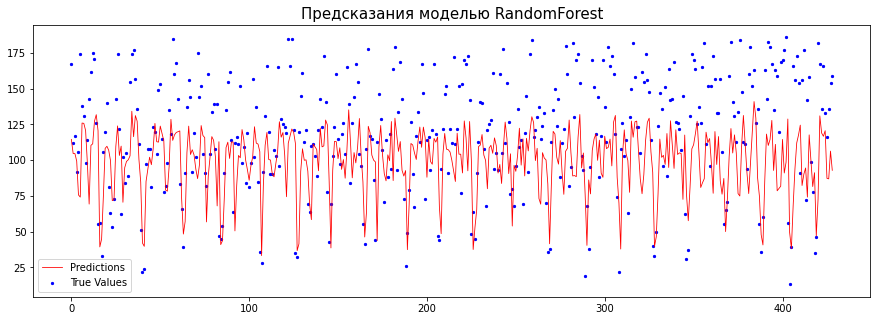

In [65]:
# визуализируем результаты предсказания
y_pred = pd.Series(rf_predictions_test)
plt.figure(figsize = (15, 5))
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="True Values")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="Predictions")
plt.legend()
plt.title('Предсказания моделью RandomForest', fontsize=15);

### Выводы
* победившая по результатам кросс-валидации модель RandomForest на тестовой выборке показала RMSE = 41.01, что соответствует условиям проекта ("Значение метрики RMSE на тестовой выборке должно быть не больше 48")
* ошибки лежат в области "выше среднего"
* для улучшения качества прогноза сервису рекомендуется достать исторические данные, которые будут прокрывать период как минимум 12 месяцев подряд, в таком случае качество прогноза повысится, у модели будет понимание сезонности, тренда, и она сможет обрабатывать пики (выбросы)